The dataset used in this project is a dataset of customers from a telecommunications company. The data was gotten from kaggle.
<br>
The purpose of this analysis is to build a classification model that predicts customer churn accurately.

In [6]:
# importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#pip install -U imbalanced-learn
import data_preprocessing as dataprep
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from imblearn.pipeline import Pipeline as sampling_pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost 
warnings.filterwarnings("ignore")
pd.set_option("max_columns",100)

In [7]:
# reading in the dataset and splitting it into a train and test set for analysis
df = pd.read_csv("train.csv")
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(df, df.churn):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [8]:
train.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,ME,123,area_code_408,no,no,0,114.4,91,19.45,216.6,123,18.41,250.6,102,11.28,11.0,3,2.97,0,no
1,MO,154,area_code_415,no,no,0,162.0,87,27.54,199.5,147,16.96,243.0,66,10.93,1.1,5,0.30,1,no


In [9]:
# creating lists of categorical and numerical columns
cat_cols = [i for i in train.columns if train[i].dtype==object]
numeric_cols = [i for i in train.columns if train[i].dtype!=object]

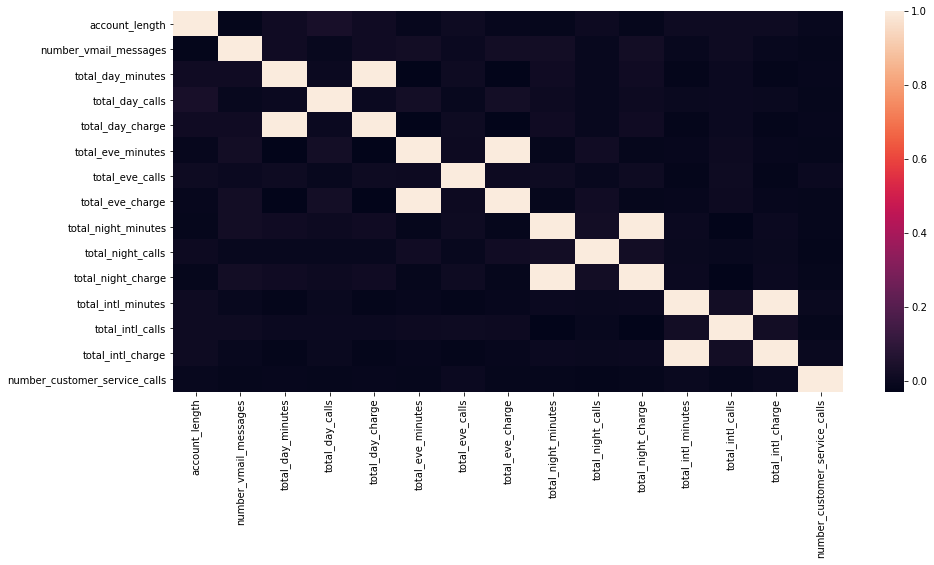

In [10]:
# plotting a heatmap of the correlation of the values in the columns
plt.figure(figsize=(15, 7))
sns.heatmap(train.corr())

The heatmap above shows very strong correlation between some variables in the dataset.
<br>
Variables with very strong correlation include:
 - total day charge and total day minutes
 - total eve charge and total eve minutes
 - total international charge and total international minutes.

<br>
It makes sense that these columns are perfectly correlated with each other as the total _ charge is a linear combination of the total _ minutes multiplied by the charge per minute.
one of each of these columns would be dropped and the other would be used.

In [11]:
# Encoding the target column and creating a list of categorical columns that would be encoded
# The state column would be dropped as it contains too many categories in it.
X, y = train.drop("churn", axis=1), train.churn
label=LabelEncoder()
y = pd.Series(label.fit_transform(y), name="churn")
cols_to_encode = cat_cols.copy()
cols_to_encode.remove("churn")
cols_to_encode.remove("state")

In [12]:
# creating a preprocessing pipeline that encodes the categorical columns using OneHotEncoder, drops the state column, drops correlated 
# columns, and scales the features in the dataset.
encoder = OneHotEncoder(cols=cols_to_encode,use_cat_names=True)
drop_cols = dataprep.Drop_cols(["state"])
return_uncorrelated= dataprep.SelectedColumns(upper_limit=0.6, lower_limit=0.85)
scaler=StandardScaler()
steps = [("encode_x", encoder),
         ("drop_cols", drop_cols),
        ("drop_correlated", return_uncorrelated),
         ("scale_features", scaler)]   
preprocess = Pipeline(steps=steps)
X = pd.DataFrame(preprocess.fit_transform(X), columns=return_uncorrelated.cols)

In [13]:
# checking the head of the transformed data
X.head(2)

,account_length,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,voice_mail_plan_no,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls
0,0.573267,1.689638,-0.977891,-0.580067,0.321216,0.592296,-1.225763,-0.439057,0.331854,1.141884,1.005425,0.117445,0.273629,-0.579246,-1.191410
1,1.348668,-0.591843,1.022608,-0.580067,0.321216,0.592296,-0.347155,-0.640575,-0.007617,2.339296,0.854311,-1.670301,-3.308076,0.238117,-0.433827


In [14]:
X.shape

(3400, 15)

Datasets involving customer churn are mostly imbalanced as the proportion of customers that do not churn is way higher than that of customers that churn; for this data set this proportion is shown below:

In [15]:
y.value_counts(normalize=True)

0    0.859412
1    0.140588
Name: churn, dtype: float64

To improve this proportion, Synthentic Minority Oversampling Technique (SMOTE) combined with Random Oversampling would be used to create a more balanced dataset for training the model.

In [16]:
# Oversampling the minority class and undersampling the majority class to create a moe balanced dataset for training the churn prediction
# model.
smote = SMOTE(sampling_strategy=0.4, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
sampling = sampling_pipeline(steps=[("over", smote), ("under", undersampler)])
X_1, y_1 = sampling.fit_resample(X, y)

In [17]:
y_1.value_counts(normalize=True)

0    0.62492
1    0.37508
Name: churn, dtype: float64

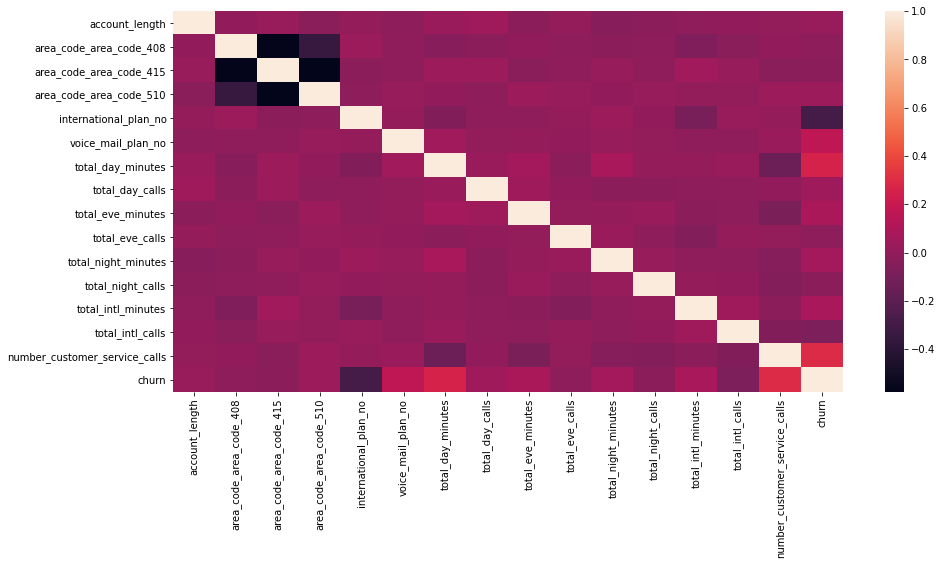

In [18]:
# merging the features and the target variable and creating a correlation plot to inspect the correlation of columns in the dataset
merged = X_1.merge(y_1, left_index=True, right_index=True)
plt.figure(figsize=(15,7))
sns.heatmap(merged.corr())

Columns show little to no correlation. Moving on to model selection

### Model Selection

Since the purpose of the model is to predict customer churn in order to reduce/prevent it, the metric that would be used for evaluating the performance of the models is the Recall.
<br>
Recall is given by: 
#### $ \frac{TP}{TP+FN} $   
Maximizing this metric would help ensure that the model accurately captures churn although it would also reduce the precision of the model leading to predicting churn for customers that are less likely to churn.

#### Logistic Regression

##### L1 Regularization

In [19]:
paraml1 = {"solver": ["saga", "sag", "liblinear"],
           "C": [0.1,0.2, 0.3, 0.35, 0.4]
          }
grid_l1 = GridSearchCV(estimator=LogisticRegression(penalty="l1"), param_grid=paraml1, n_jobs=-1, scoring="recall",
                      return_train_score=True)
grid_l1.fit(X_1, y_1)

GridSearchCV(estimator=LogisticRegression(penalty='l1'), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.35, 0.4],
                         'solver': ['saga', 'sag', 'liblinear']},
             return_train_score=True, scoring='recall')

In [20]:
grid_l1.best_score_

0.6292652507244781

In [21]:
grid_l1.best_params_

{'C': 0.2, 'solver': 'liblinear'}

In [22]:
pd.DataFrame(grid_l1.cv_results_).sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.011118,0.001641,0.0048,0.000747,0.2,liblinear,"{'C': 0.2, 'solver': 'liblinear'}",0.600858,0.645299,0.636752,0.623932,0.639485,0.629265,0.01583,1,0.634225,0.638116,0.634904,0.627409,0.631016,0.633134,0.003644


##### L2 Regularization

In [23]:
paraml2 = {"solver": ["sag", "saga", "newton-cg", "lbfgs"],
           "C": [0.4, 0.6,0.8,1.0,1.2]    
}
grid_l2 = GridSearchCV(LogisticRegression(penalty="l2"), param_grid=paraml2, scoring="recall", n_jobs=-1, return_train_score=True, cv=10)
grid_l2.fit(X_1, y_1)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.4, 0.6, 0.8, 1.0, 1.2],
                         'solver': ['sag', 'saga', 'newton-cg', 'lbfgs']},
             return_train_score=True, scoring='recall')

In [24]:
grid_l2.best_score_

0.6224580017683465

In [25]:
grid_l2.best_params_

{'C': 0.4, 'solver': 'sag'}

In [26]:
pd.DataFrame(grid_l2.cv_results_).sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.029874,0.00164,0.004243,0.001076,0.4,sag,"{'C': 0.4, 'solver': 'sag'}",0.623932,0.555556,0.623932,0.641026,0.577586,0.698276,0.65812,0.57265,0.623932,0.649573,0.622458,0.041324,1,0.627973,0.631779,0.627973,0.635585,0.642586,0.620722,0.624167,0.633682,0.641294,0.621313,0.630708,0.007298


#### SVC

In [27]:
param_svc = {"gamma": [0.003, 0.004, 0.005, 0.007, 0.009],
            "C":[16, 17, 18, 19]
           }
grid_svc = GridSearchCV(estimator=SVC(class_weight="balanced", random_state=42), n_jobs=-1, scoring="recall", return_train_score=True, cv=5,
                        param_grid = param_svc)
grid_svc.fit(X_1, y_1)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'C': [16, 17, 18, 19],
                         'gamma': [0.003, 0.004, 0.005, 0.007, 0.009]},
             return_train_score=True, scoring='recall')

In [28]:
grid_svc.best_score_

0.8578482080628003

In [29]:
grid_svc.best_params_

{'C': 17, 'gamma': 0.004}

In [30]:
pd.DataFrame(grid_svc.cv_results_).sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.367839,0.01132,0.182588,0.01656,17,0.004,"{'C': 17, 'gamma': 0.004}",0.819742,0.871795,0.863248,0.871795,0.862661,0.857848,0.01946,1,0.872727,0.869379,0.87045,0.865096,0.862032,0.867937,0.003854


In [31]:
train_score_svc = grid_svc.score(X_1, y_1)

#### Random Forest Classifier

In [32]:
param_rfc = {#"n_estimators": [900, 1000],
             "max_features": [4, 6, 8, 10],
#             "bootstrap": [True, False],
#             "max_depth": [5, 10, 15],
             "min_samples_split": [26,27,28, 29],
#             "max_leaf_nodes":[15,18, 20]
            }
grid_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42,n_estimators=900), n_jobs=-1, scoring="recall", 
                        return_train_score=True,param_grid=param_rfc, verbose=1, cv=10)
grid_rfc.fit(X_1, y_1)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=900,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [4, 6, 8, 10],
                         'min_samples_split': [26, 27, 28, 29]},
             return_train_score=True, scoring='recall', verbose=1)

In [33]:
print("best score Random Forest Classifier:", grid_rfc.best_score_)
print("best parameters Random Forest Classifier:", grid_rfc.best_params_)

best score Random Forest Classifier: 0.8476201002063073
best parameters Random Forest Classifier: {'max_features': 4, 'min_samples_split': 29}


In [34]:
pd.DataFrame(grid_rfc.cv_results_).sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
3,8.684048,0.208285,0.253842,0.013507,4,29,"{'max_features': 4, 'min_samples_split': 29}",0.803419,0.777778,0.82906,0.863248,0.844828,0.87069,0.871795,0.880342,0.880342,0.854701,0.84762,0.032766,1,0.895338,0.900095,0.901047,0.891532,0.890684,0.888783,0.88392,0.891532,0.885823,0.887726,0.891648,0.005399


In [35]:
train_score_rfc = grid_rfc.score(X_1, y_1)

In [36]:
train_score_rfc

0.8938356164383562

### XGboost

In [37]:
params_xgb = {#"n_estimators": [100, 150, 200, 300],
#              "max_depth":[1,3,5],
              "learning_rate": [0.4,0.5, 0.6, 0.7, 0.8, 0.9],
             }
grid_xgb = GridSearchCV(estimator=xgboost.XGBClassifier(random_state=42, max_depth=2, n_estimators=100), n_jobs=-1, 
                        verbose=1,param_grid=params_xgb, scoring="recall", return_train_score=True)
grid_xgb.fit(X_1,y_1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [38]:
grid_xgb.best_score_

0.877524668940978

In [39]:
grid_xgb.best_params_

{'learning_rate': 0.8}

In [40]:
pd.DataFrame(grid_xgb.cv_results_).sort_values(by="rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,0.219743,0.008124,0.003515,0.002224,0.8,{'learning_rate': 0.8},0.738197,0.760684,0.965812,0.957265,0.965665,0.877525,0.104867,1,0.975401,0.961456,0.947537,0.931478,0.934759,0.950126,0.016479


In [41]:
train_score_xgb = grid_xgb.score(X_1, y_1)

#### Top three models

From the cross-validation with grid search for the right hyperparameters and parameters for the models, the top three best performing models
are:

In [42]:
pd.DataFrame({"Model": ["XGBoost", "Random Forest", "Kernel SVM"],
             "Best Average CV Grid_score": [grid_xgb.best_score_, grid_rfc.best_score_, grid_svc.best_score_],
             "Score on Training Data": [train_score_xgb, train_score_rfc, train_score_svc]})

,Model,Best Average CV Grid_score,Score on Training Data
0,XGBoost,0.877525,0.940925
1,Random Forest,0.847620,0.893836
2,Kernel SVM,0.857848,0.870719


##### Applying the top three models on the test set.

In [43]:
# applying preprocessing the same preprocessing applied on the train set to the test set
X_test, y_test = test.drop("churn", axis=1), test.churn
X_test = pd.DataFrame(preprocess.transform(X_test), columns=return_uncorrelated.cols)
y_test = pd.Series(label.transform(y_test), name="churn")

In [44]:
# evaluating all top three models on the test set
grid_xgb_test_score = grid_xgb.score(X_test, y_test)
grid_rfc_test_score = grid_rfc.score(X_test, y_test)
grid_svc_test_score = grid_svc.score(X_test, y_test)
test_performance = pd.DataFrame({"XGBoost": grid_xgb_test_score,
                                "Random Forest Classifier": grid_rfc_test_score,
                                "Support Vector Classifier": grid_svc_test_score}, index=[0])
test_performance

,XGBoost,Random Forest Classifier,Support Vector Classifier
0,0.758333,0.783333,0.858333


Random Forest Classifier has the highest recall on the test among the top three models.
<br>
The classification report, confusion matrix and accuracy of these models are shown below:

In [45]:
# classification report for the Random Forest Classifier
print(classification_report(y_test, grid_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       730
           1       0.84      0.78      0.81       120

    accuracy                           0.95       850
   macro avg       0.90      0.88      0.89       850
weighted avg       0.95      0.95      0.95       850



In [46]:
# classification report for the XGBoost Classifier 
print(classification_report(y_test, grid_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       730
           1       0.90      0.76      0.82       120

    accuracy                           0.95       850
   macro avg       0.93      0.87      0.90       850
weighted avg       0.95      0.95      0.95       850



In [47]:
# classification report for the Support Vector Classifier
print(classification_report(y_test, grid_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       730
           1       0.50      0.86      0.63       120

    accuracy                           0.86       850
   macro avg       0.73      0.86      0.77       850
weighted avg       0.91      0.86      0.87       850



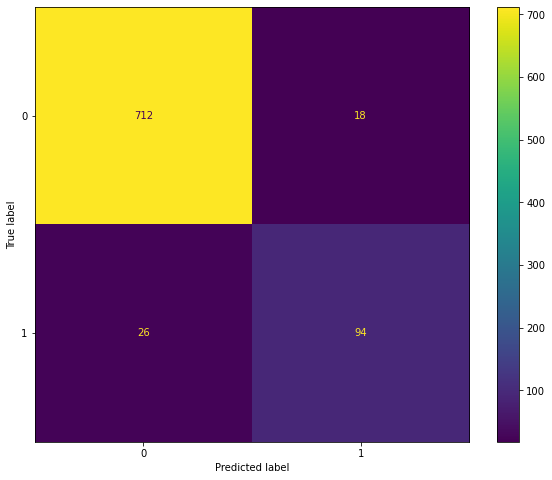

In [48]:
# Confusion matrix for the Random Forest Classifier
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(estimator=grid_rfc, X=X_test, y_true=y_test, ax=ax)

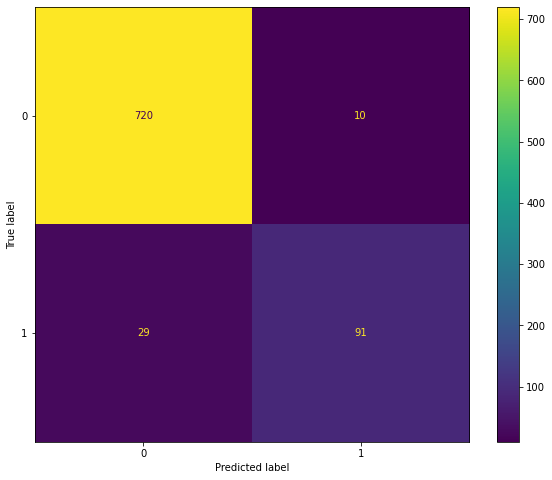

In [49]:
# Confusion matrix for the XGBoost Classifier
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(estimator=grid_xgb, X=X_test, y_true=y_test, ax=ax)

In [51]:
# Accuracy of the Random Forest Model
TN, FP = confusion_matrix(y_test, grid_rfc.predict(X_test))[0]
FN, TP = confusion_matrix(y_test, grid_rfc.predict(X_test))[1]
accuracy = (TP+TN)/(TP+TN+FP+FN)
print("accuracy of best Random Forest Model is" , accuracy)

accuracy of best Random Forest Model is 0.9482352941176471


In [52]:
# Accuracy of the XGBoost Model
TN, FP = confusion_matrix(y_test, grid_xgb.predict(X_test))[0]
FN, TP = confusion_matrix(y_test, grid_xgb.predict(X_test))[1]
accuracy = (TP+TN)/(TP+TN+FP+FN)
print("accuracy of best XGBoost Model on the test set is", accuracy)

accuracy of best XGBoost Model on the test set is 0.9541176470588235


Text(0.5, 0, 'Relative Importance')

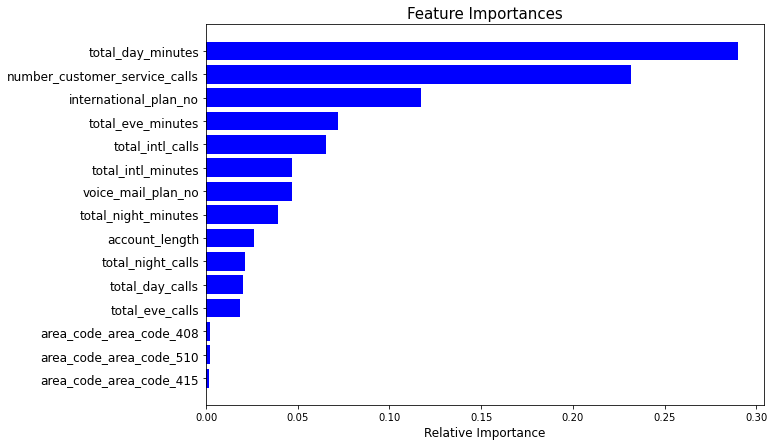

In [53]:
# Feature importance plot of the Random Forest Classifier
features = X_1.columns
importances = grid_rfc.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 7))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.title("Feature Importances", fontsize=15)
plt.yticks(range(len(indices)), features[indices],fontsize=12)
plt.xlabel('Relative Importance', fontsize=12)